In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [80]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_path = '/content/drive/MyDrive/UCMerced_LandUse/UCMerced_LandUse/Images_converted'
dataset = ImageFolder(root=data_path, transform=transform)

train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [81]:
import timm
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('seresnet50', pretrained=True)

num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [82]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
epochs = 25

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(valid_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/25, Train Loss: 1.7005, Train Acc: 56.19%, Val Loss: 0.4257, Val Acc: 87.94%
Epoch 2/25, Train Loss: 0.2503, Train Acc: 92.45%, Val Loss: 0.2511, Val Acc: 92.38%
Epoch 3/25, Train Loss: 0.1224, Train Acc: 96.67%, Val Loss: 0.2139, Val Acc: 94.29%
Epoch 4/25, Train Loss: 0.0756, Train Acc: 97.62%, Val Loss: 0.2367, Val Acc: 92.70%
Epoch 5/25, Train Loss: 0.1048, Train Acc: 97.07%, Val Loss: 0.1641, Val Acc: 95.56%
Epoch 6/25, Train Loss: 0.0636, Train Acc: 98.71%, Val Loss: 0.1340, Val Acc: 96.83%
Epoch 7/25, Train Loss: 0.0208, Train Acc: 99.52%, Val Loss: 0.1038, Val Acc: 96.19%
Epoch 8/25, Train Loss: 0.0215, Train Acc: 99.39%, Val Loss: 0.1288, Val Acc: 96.19%
Epoch 9/25, Train Loss: 0.0103, Train Acc: 99.86%, Val Loss: 0.0835, Val Acc: 97.46%
Epoch 10/25, Train Loss: 0.0079, Train Acc: 99.86%, Val Loss: 0.0945, Val Acc: 97.78%
Epoch 11/25, Train Loss: 0.0071, Train Acc: 99.86%, Val Loss: 0.0861, Val Acc: 97.78%
Epoch 12/25, Train Loss: 0.0041, Train Acc: 99.93%, Val Loss: 0

In [83]:
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 97.78%


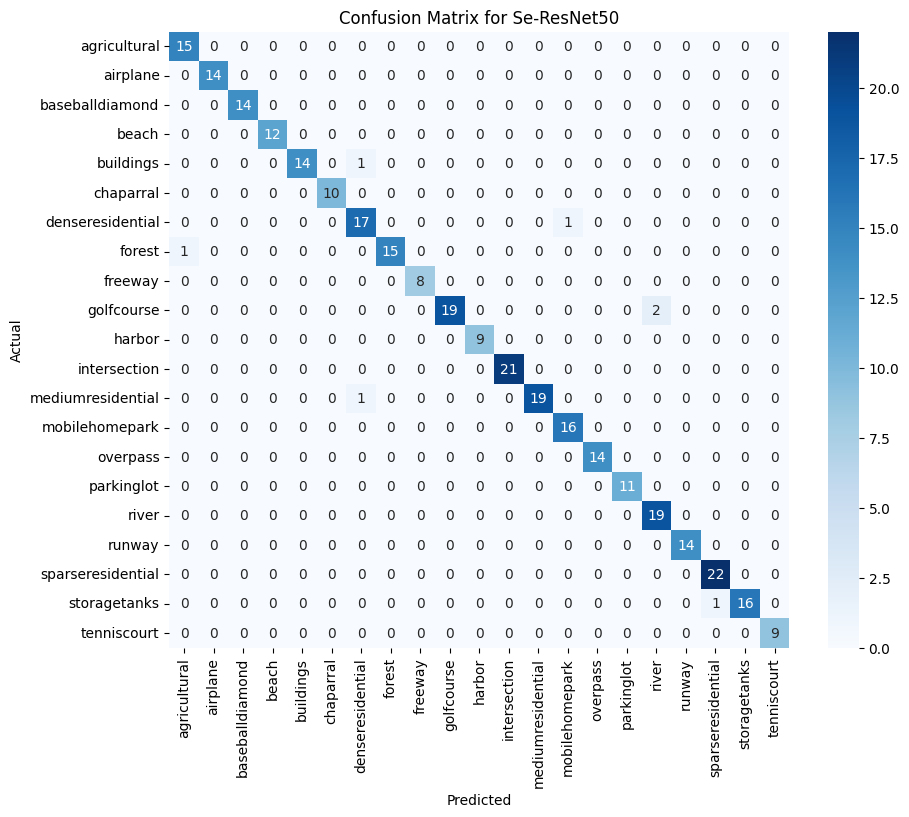

Classification Report:
                   precision    recall  f1-score   support

     agricultural       0.94      1.00      0.97        15
         airplane       1.00      1.00      1.00        14
  baseballdiamond       1.00      1.00      1.00        14
            beach       1.00      1.00      1.00        12
        buildings       1.00      0.93      0.97        15
        chaparral       1.00      1.00      1.00        10
 denseresidential       0.89      0.94      0.92        18
           forest       1.00      0.94      0.97        16
          freeway       1.00      1.00      1.00         8
       golfcourse       1.00      0.90      0.95        21
           harbor       1.00      1.00      1.00         9
     intersection       1.00      1.00      1.00        21
mediumresidential       1.00      0.95      0.97        20
   mobilehomepark       0.94      1.00      0.97        16
         overpass       1.00      1.00      1.00        14
       parkinglot       1.00    

In [95]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Se-ResNet50')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


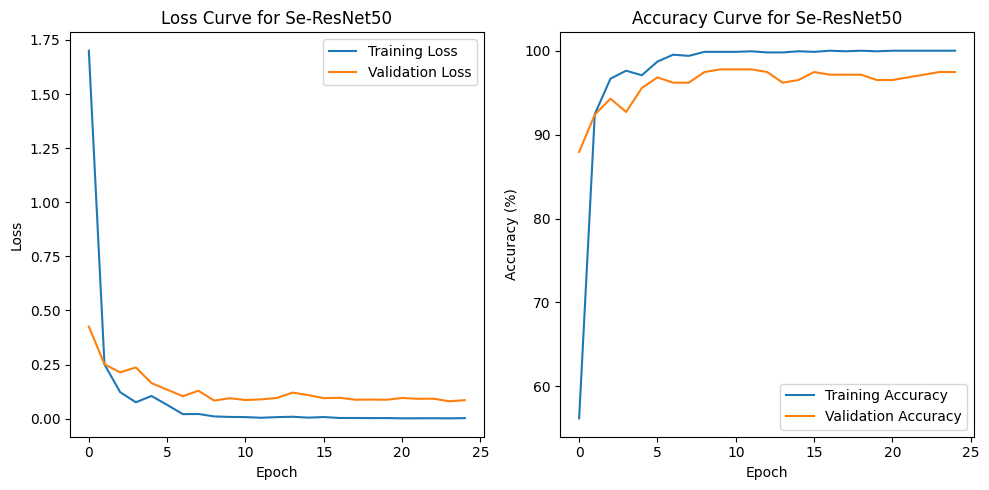

In [87]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve for Se-ResNet50')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve for Se-ResNet50')

plt.tight_layout()
plt.show()


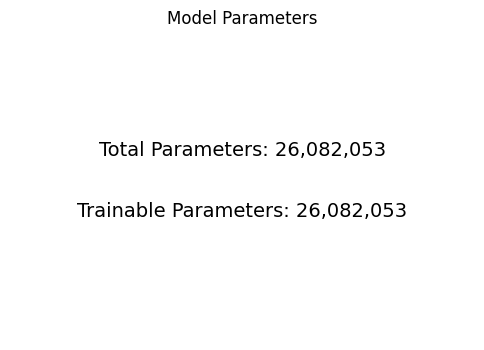

In [89]:
import matplotlib.pyplot as plt

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

plt.figure(figsize=(6, 4))
plt.text(0.5, 0.6, f"Total Parameters: {total_params:,}", ha='center', fontsize=14)
plt.text(0.5, 0.4, f"Trainable Parameters: {trainable_params:,}", ha='center', fontsize=14)
plt.axis('off')
plt.title("Model Parameters")
plt.savefig("parameters_image.png")
plt.show()

In [90]:
from torchsummary import summary
from torchviz import make_dot

summary(model, input_size=(3, 224, 224))
dot = make_dot(model(torch.randn(1, 3, 224, 224).to(device)), params=dict(model.named_parameters()))
dot.render("model_architecture", format="png")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
         Identity-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
         Identity-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

'model_architecture.png'

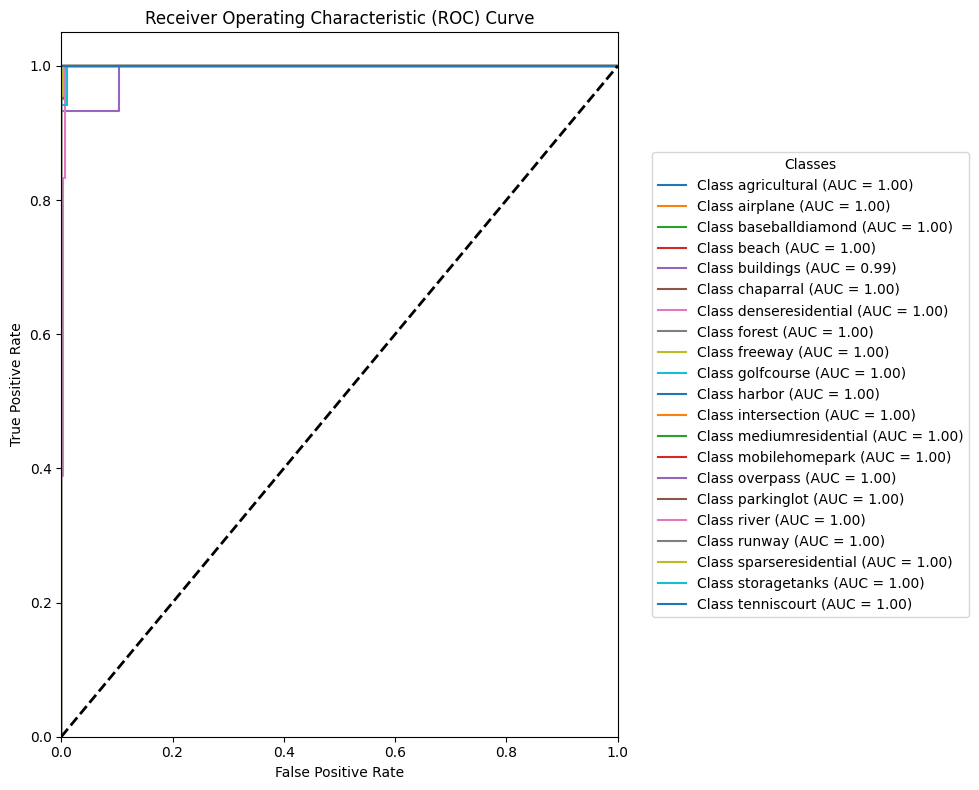

In [93]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
y_true_bin = label_binarize(all_labels, classes=np.arange(num_classes))
all_preds_prob = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        all_preds_prob.extend(probs.cpu().numpy())
y_pred_prob = np.array(all_preds_prob)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Classes", fontsize=10)
plt.tight_layout()
plt.show()


Saving tenniscourt98.jpg to tenniscourt98 (3).jpg


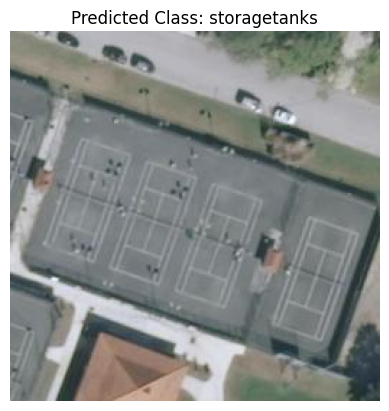

In [102]:
from google.colab import files
import matplotlib.pyplot as plt
import torch
uploaded = files.upload()
image_name = list(uploaded.keys())[0]
from PIL import Image
img = Image.open(image_name)
img = transform(img).unsqueeze(0).to(device)

with torch.no_grad():
  model.eval()
  outputs = model(img)
  _, predicted = torch.max(outputs, 1)
plt.imshow(Image.open(image_name))
plt.axis('off')
plt.title(f"Predicted Class: {dataset.classes[predicted.item()]}")
plt.show()